![Banner](media/CATE-ITC-Banner.png)

# Exploring the Drought in Kenya using Soil Moisture
Exercise 01: Land

![Drought](media/Land_logo.png)

Photo credit: ESA

Authors: Elnaz Neinavaz, Roelof Rietbroek

Last update: 15th of Jan 2021

License: 
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>

# 1. Introduction to the exercise
Kenya is a drought-prone country, mainly due to its peculiar environmental conditions. While agriculture supports up to 75% of Kenya's population and generates almost all food requirements, drought is a major constraint on rain-fed agricultural production, particularly in arid and semi-arid Kenya. In the last century, Kenya has faced almost 29 droughts, some of them in the last decade. The frequency and severity of droughts in Kenya seems to be increasing over time. As a result, crop failures and livestock deaths are leading to severe food shortages in Kenya and food insecurity. [The Climate Change Initiative hosts a soil moisture dataset](https://esa-soilmoisture-cci.org/) that can be used to generate an index of draught severity called Drought Index. In this exercise, we apply the soil moisture data to generate this Drought Indicator for Kenya.

![workflow](media/SM%20exercise%20kenya.png)
The input data is daily images of soil moisture (SM, m3/m3) for Kenya and for a number of years (2000.01.01-2020.01.01).
There are several approaches to obtaining periods of droughts following information on soil moisture. In this xcercise, we follow the Soil Moisture Deficit Index to address drought in Kenya.

1. Download the daily SM images for the area of interest and for the period considered 
2. Extract the agricultural area using landcover map
3. Calculate the average SM per month
4. Group the monthly SM by month (all monthly SM of January, February, etc.) for the time span concerned
5. Calculate the median, maximum, and minimum values per pixel of the long term monthly images. Three images per month
6. With the actual image of the SM of a given month (SWj), calculate the monthly soil deficit of the month (SDj)
7. With (SDj) and the Soil Moisture Deficit Index of the month (j-1) (SMDIj-1), calculate the SMDIj. Note: SMDI1= SD1/50 for initial month
8. -4 <= SMDIj <= 4 indicating from very dry to very wet conditions
9. Identify the very dry areas by identifying a consecutive number of months of negative SMDIj.
10. Identify the year and the months of the very dry area in Kenya


## 1.1. Exercise objectives
In this exercise you will learn to use Cate in order to:
1. Search for soil moisture data from the [ESA CCI Open data portal](https://climate.esa.int/en/odp/#/dashboard)
2. Apply the soil moisture data to generate information required for the drought model
3. Create a drought index based on soil moisture dataset for Kenya
4. Identify periods and regions of drought over Kenya

## Getting started with jupyter notebooks and the cate webui
Todo: add hyperlink to general instructions on setting up Cate

## 1.2. Are you ready to go?
Please follow the steps below, and run all the code cells step by step
Here are a few technical reminders:
* `tabs` play an important role in python and remove the need for brackets. If you incorrectly align you code, it will not run and you'll get alignment errors.
* you can execute **code cells**, by selecting the cell and pressing either the *play* button or pressing `Ctrl+Enter`
* Indexing in python is 0-based (i.e. the first entry is denoted by 0)
* You're encouraged to try out different settings

## 1.3. Initializing some modules 

In [17]:
#Load some parts of the cate module so we can communicate with its datastore
from cate.core.ds import DATA_STORE_REGISTRY
import cate.ops as ops
from cate.util.monitor import ConsoleMonitor
from datetime import datetime
import cartopy.feature as cfeature #needed to get natural earth shapes
from shapely import wkt # needed later when we apply region constraints
import xarray as xr
import numpy as np
import logging
import os
# plotting tools
import matplotlib.pyplot as plt
import cartopy.crs as ccrs #to work with geographical projections
import pandas as pd
%matplotlib inline

import logging

# There are some irrelevant warnings later which we want to suppressed 
logging.captureWarnings(True) #although when developing code it's usually better to keep this disabled)

#We need this temporary hack to work around (https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop)
import nest_asyncio
nest_asyncio.apply()



    


In [2]:
# We're going to need to talk to the online data store

## This one is online and connects to ESA's CCI open data portal
onlineStore = DATA_STORE_REGISTRY.get_data_store('esa_cci_odp_os')


## The monitor below may be used to facilitate logging of output
monitor=ConsoleMonitor(stay_in_line=True)

# 2. Find the required data in ESA's CCI Open Data Portal

Let's start with finding 'Soil Moisture', and 'Land Cover' data by querying for the Essential Climate Variables name `SOILMOISTURE` and `LAND_COVER`



In [3]:
# soilmoistureQuery=data_store.query(query_expr="esacci.SOILMOISTURE.day.L3S.SSMS.multi-sensor.multi-platform.ACTIVE.05-2.r1")
soilmoistureQuery=onlineStore.query(query_expr="SOILMOISTURE")

# landcoverQuery=data_store.query(query_expr="esacci.SOILMOISTURE.day.L3S.SSMS.multi-sensor.multi-platform.ACTIVE.05-2.r1") ?????
landcoverQuery=onlineStore.query(query_expr="LAND_COVER")

Let's have a look in what we found



In [ ]:

# We may find multiple data sources for the 'soil moisture',  which match the criteria, so let's see how many 
print("Found %d Soil moisture data sources"%(len(soilmoistureQuery)))
for datasrc in soilmoistureQuery:
    print(datasrc.title)
    
    
print("Found %d Land cover data sources"%(len(landcoverQuery)))
for datasrc in landcoverQuery:
    print(datasrc.title)
    
    
# are you interested in more details? Try printing out some meta information of the found datasets
print(landcoverQuery[0].meta_info)


## 2.1. Questions
A number of checks need to be done over the avilable datasets:
1. Note down the units of the soil Moisture maps for information.
2. What kind of classes do you need to find agricultural areas?
3. Who should you cite when using this datasets?

# 3. Download (a subset of) the data and store it 'locally'
Up to now, we just queried the open data portal but did not actually download or process any data. In the following steps you will be extracting the required data by setting constraints in time and space to reduce the data download. The soil moisture data will aslo be sampled on monthly intervals before being stored locally






## 3.1. Apply a regional restriction based on a hand-drawn polygon
Polygons, and other geometr directoryical objects in GIS systems can be conveniently expressed in the [Well Known Text representation (WKT)](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry). The polygon below `Polygon (( ...))`, was drawn using [QGIS](https://www.qgis.org/en/site/) and exported as WKT. We furthermore need to load this in a [Shapely Polygon object](https://shapely.readthedocs.io/en/stable/manual.html?highlight=Polygon#Polygon) so cate can work with.

/usr/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/lib/python3.9/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


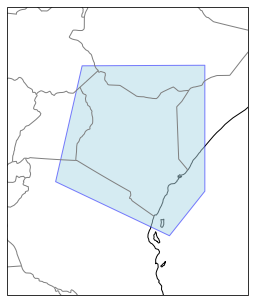

In [4]:
# The WKT representation representing the rough outline of the Kenya as a region of interest 

wktkenyaDrought="Polygon ((34.0218774057365323 5.83180890691609211, 43.11430983816897111 5.80626836637555233, 42.62903956789870108 -3.10738028227309826, 40.17714767600680403 -5.96792082281363712, 32.5660665949257222 -2.494407309300124, 32.5660665949257222 -2.494407309300124, 32.5660665949257222 -2.494407309300124, 34.0218774057365323 5.83180890691609211))"
KenyaPoly=wkt.loads(wktkenyaDrought)

mapproj=ccrs.LambertConformal(central_longitude= 37.9,central_latitude=-0.02)
# Curious as you might be, let's make a quick and dirty plot to see how the polygon looks like on a map
ax = plt.axes([0, 0, 1, 1],projection=mapproj)
ax.set_extent([30, 45, 10, -10])
ax.coastlines()
ax.add_geometries([KenyaPoly],crs=ccrs.PlateCarree(),facecolor="lightblue",edgecolor="blue",alpha=0.5)

#spice up your plot with some Natural Earth country boundaries
ax.add_feature(cfeature.BORDERS, edgecolor='gray')


In [5]:
# Resample soil moisture on monthly averages
def saveToLocalDs(localName,xrData):
    """Quick function to Save and xarray DataSet to a local datasource"""
    #open the local store
    localStore = DATA_STORE_REGISTRY.get_data_store('local')
    fout=localStore.data_store_path+"/local."+localName+"/local."+localName+".nc"
    
    trange=[pd.to_datetime(xrData.time.min().data),pd.to_datetime(xrData.time.max().data)]
 
    # the directly may not exists so make sure to create it
    try:
        os.mkdir(os.path.dirname(fout))
    except FileExistsError:
        pass
    monitor=ConsoleMonitor(stay_in_line=True)
#     ops.save_dataset(ds=xrData,file=fout,monitor=monitor)

    #Create a cate compatible datasource
    local_id="local."+localName
    localDs=localStore.create_data_source(local_id,title=local_id,time_range=trange)
    # Add the newly created netcdf file to local datasource
    localDs.add_dataset(fout)
    localStore.register_ds(localDs)
    return localDs
    
svarName="SoilmoistureMonthly_Kenya"

# Create monthly averages from the opendap dataset
combinedId=2

#apply time constraint
withinT=[datetime(2015,1,1),datetime(2016,1,1)]
#withinT=[datetime(2010,1,1),datetime(2020,1,1)]

In [14]:
#uncomment to actually apply the monthly sampling
# smdat=soilmoistureQuery[combinedId].open_dataset(region=KenyaPoly,time_range=withinT)
# smMonDset=ops.temporal_aggregation(ds=smdat,output_resolution="month",method="mean")

# #Download a subset based upon region and time constraints from the online store:
#soilmoistureComb=saveToLocalDs(svarName,smMonDset)

In [6]:
# Quicker (if you've downloaded the data before) Retrieve the monthly data from your local store
localStore= DATA_STORE_REGISTRY.get_data_store('local')
#localStore.invalidate() this may be needed to reload the local store catalogue
smid="local.%s"%(svarName)
soilmoistureComb=localStore.query(ds_id=smid)[0] #note that we take the first element from the list (we only expect one entry)

In [7]:
#Download Landcover data
lcvarName="Land_cover_Keyna2015"


# Retrieve form the online store and download for local use
# landId=1 # we take the 2nd dataset (remember we're using 0-indexed lists in python)
# withinT=[datetime(2015,1,1),datetime(2015,12,31)]
# lc=landcoverQuery[landId].make_local(local_name=lcvarName,monitor=monitor,time_range=withinT,region=KenyaPoly)

# Quicker (if you've downloaded the data before) Retrieve the data from your local store
#localStore.invalidate() this may be needed to reload the local store catalogue
lcid="local.%s"%(lcvarName)
landcover=localStore.query(ds_id=lcid)[0] #note that we take the first element from the list (we only expect one entry)

## 3.2. Once we have downloaded the data let's see what we actually got

In [ ]:
print(landcover.variables_info)
print(soilmoistureComb.variables_info)

In [8]:
# open the datasets (this will return xarray datasets). Note we will restrict the loaded variables such that not too much data is loaded in memory
lcdata=landcover.open_dataset(var_names=["lccs_class"])
smdata=soilmoistureComb.open_dataset(var_names=["sm"])


# 4. Extract 'Agricultural Area' class from land cover map 

Use the agricultural area class to extract soil moisture for the agricultural area.
First, we need to create a mask based on the land cover class

0 no_data
10 cropland_rainfed
11 cropland_rainfed_herbaceous_cover
12 cropland_rainfed_tree_or_shrub_cover
20 cropland_irrigated
30 mosaic_cropland
40 mosaic_natural_vegetation
50 tree_broadleaved_evergreen_closed_to_open
60 tree_broadleaved_deciduous_closed_to_open
61 tree_broadleaved_deciduous_closed
62 tree_broadleaved_deciduous_open
70 tree_needleleaved_evergreen_closed_to_open
71 tree_needleleaved_evergreen_closed
72 tree_needleleaved_evergreen_open
80 tree_needleleaved_deciduous_closed_to_open
81 tree_needleleaved_deciduous_closed
82 tree_needleleaved_deciduous_open
90 tree_mixed
100 mosaic_tree_and_shrub
110 mosaic_herbaceous
120 shrubland
121 shrubland_evergreen
122 shrubland_deciduous
-126 grassland
-116 lichens_and_mosses
-106 sparse_vegetation
-105 sparse_tree
-104 sparse_shrub
-103 sparse_herbaceous
-96 tree_cover_flooded_fresh_or_brakish_water
-86 tree_cover_flooded_saline_water
-76 shrub_or_herbaceous_cover_flooded
-66 urban
-56 bare_areas
-55 bare_areas_consolidated
-54 

/usr/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  func(*args, **kwargs)


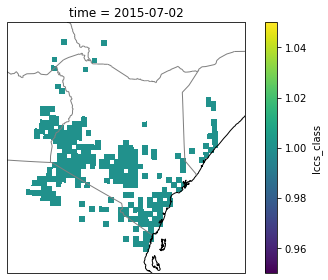

In [9]:
# print the land cover attributes (note: we need to split nameing at whitespace) and search for
for val,flag in zip(lcdata.lccs_class.attrs["flag_values"],lcdata.lccs_class.attrs["flag_meanings"].split()):
     print(val,flag)

#Let's make a list of the classes we're interested
import re
# in this case let's gather all classes which have 'crop' in it's name
agriclasses=[val for val,flag in zip(lcdata.lccs_class.attrs["flag_values"],lcdata.lccs_class.attrs["flag_meanings"].split()) if re.search('cropland',flag)]

# create  a mask and remove the time axis (it has only one coordinate)
mask=lcdata.lccs_class.isin(agriclasses).squeeze('time')

#interpolate mask onto the soil moisture grid so it can be more easily applied
masksm=mask.astype(int).interp(lat=smdata.lat,lon=smdata.lon,method='nearest')
masksm=masksm.where(masksm == 1) # set the 0 values to Nan (not a numbers)


# you can make a plot of the mask if you're interested
p = masksm.plot(transform=ccrs.PlateCarree(),subplot_kws={"projection": mapproj})
p.axes.coastlines()
p.axes.add_feature(cfeature.BORDERS, edgecolor='gray')


# 5. To identify drought periods we need to compute the so called *Soil Moisture Deficit Index*

How to compute the Soil Moisture Deficit Index (SMDI)


For soil moisture the method we will use is called the Soil moisture deficit index (SMDI). It is a solution where the soil moisture of the previous month is used to calculate the SMDI of the actual month. A loop is used t cover the whole series. 

Variables
1. ${SMDI}_j$= soil moisture deficit index of the month j
2. ${SMDI}_{j-1}$= SMDI at month j-1 (previous month) 
3. $SD_j$ = monthly soil deficit at month j  
4. $SW_j$ = actual monthly soil moisture at month j.The is the soil moiture map corresponding to a certain map
5. $MSW_j$= long-term monthly **median** available soil water at month j. There will be 12 maps, one per month.
6. $maxSW_j$= long-term monthly **maximum** available soil water at month j. There will be 12 maps, one per month.
7. $minSW_j$ = long-term monthly **minimum** available soil water at month j. There will be 12 maps, one per month.
8. NOTE: $_j-1$ stands for the month previous to month j.

## The sequence of the equations are:
1. Calculate: $MSW_j$, $maxSW_j$, $minSW_j$
2. Calculate the monthly soil deficit for the month j
$$SD_j = (SW_j – MSW_j)/(maxSW_j – SW_j) *100,\quad  if SWj > MSWj$$ 
$$SD_j= (SW_j – MSW_j)/(MSW_j – minSW_j)* 100,\quad  if SW_j =< MSW_j$$ 
3. Calculate the soil moisture deficit index dor the month 1 (estimated and initial value)
$SMDI_1 = SD_1/50$  for initial month 
4. Calculate the soil moistiure deficit index for all the other months
$${SMDI}_j= 0.5 * {SMDI}_{j-1}+SD_j/50$$

The $SMDI i a value going from -4 to 4 being the negatives indicators of drought. Persistant drought can be detected by monthly accumulation of negatives SMDI giving room to a number of analysis.

In [36]:
# get the median, min and max for all Jan's, Feb's etc.
smClim=smdata.sm.groupby("time.month")
smMed=smClim.median()
smMin=smClim.min()
smMax=smClim.max()


In [52]:
# allocate enough data to hold the result (create an xarray.DataArray, and copy the coordinate axes lon,lat,time from the orginal dataset)

#Allocate the Soil Moisture deficit index
smdIndex = xr.DataArray(np.zeros(smdata.sm.shape),name="smd_indx",dims=["time","lat","lon"],coords={"lon":smdata.lon,"lat":smdata.lat,"time":smdata.time})

for i,dt in enumerate(smdata.time.to_pandas()):
    #Monthly anomaly w.r.t. long term climatological median
    print("Compute Soil moisture deficit for %d, %s"%(i,str(dt)),end='\r')
    dSm=smdata.sm[i,:,:]-smMed[dt.month-1,:,:]
    smMed_m_min=smMed[dt.month-1,:,:]-smMin[dt.month-1,:,:]
    smMax_m_med=smMax[dt.month-1,:,:]-smMed[dt.month-1,:,:]
    smd=100*xr.where(dSm < 0,dSm/smMed_m_min,dSm/smMax_m_med)
    #also mask results in the pixels of interest only
    smd=masksm*smd
    if i == 0:
        smdIndex[i,:,:]=smd/50
    else:
        smdIndex[i,:,:]=0.5*smdIndex[i-1,:,:]+smd/50

# 6. Results analysis


## 6.1. Create a geographical plot at a certain time

Create a geographical plot at a certain time, and at certain key locations (e.g., Turkana, Mandera, Marsabit, Garissa, Wajir, Isiolo, Tana River, Machakos, Makueni, and Kitu)

In [ ]:
it=10
epoch=smdIndex.time[it].data
print("Plotting epoch %s"%str(epoch))
ax = plt.subplot(projection=mapproj)
p = smdIndex.sel(time=epoch).plot(ax=ax,transform=ccrs.PlateCarree())
p.axes.coastlines()
p.axes.set_title("Soil moisture deficit index at %s"%(str(epoch)[:10]))


# 7. Questions
1. Try creating a time plot of the monthly mean of the SMDI
2. Identify the very dry areas by identifying a consecutive number of months of negative SMDIj.
3. Create a plot durng the draought period at certain key locations (e.g., Turkana, Mandera, Marsabit, Garissa, Wajir, Isiolo, Tana River, Machakos, Makueni, and Kitu)
3. Identify the year, and the months of the very dry area in Kenya.
4. Check out the 'https://foodsecurityindex.eiu.com/Country' and determoine the Global food security index for Kenya.
5. Check out the 'http://www.fao.org/publications/sofi/2020/en/' for Kenya and the interpret the number of undernourished people in that country.